In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

In [4]:
alps_wp = np.repeat(alps[np.newaxis, :, :], 140, axis=0)
alps_wp.shape

(140, 91, 139)

In [5]:

yrly_tas_MPIhist_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy')
yrly_tas_MPI245_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy')
yrly_tas_MPI585_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy')

In [6]:
yrly_tas_ECEarth_hist_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy')
yrly_tas_ECEarth_245_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy')

In [7]:
preindustrial_mean_MPI = yrly_tas_MPIhist_globalmean[:50].mean()
preindustrial_mean_MPI

4.808252

In [8]:
preindustrial_mean_ECEarth = yrly_tas_ECEarth_hist_globalmean[:50].mean()
preindustrial_mean_ECEarth

5.0014043

In [9]:
yrly_warming_MPIhist = yrly_tas_MPIhist_globalmean[111:] - preindustrial_mean_MPI # hist is now 1961-2014
yrly_warming_MPI245 = yrly_tas_MPI245_globalmean - preindustrial_mean_MPI
yrly_warming_MPI585 = yrly_tas_MPI585_globalmean - preindustrial_mean_MPI

yrly_warming_MPIhist.shape

(54,)

In [19]:
yrly_warming_MPI245 = np.concatenate([yrly_warming_MPIhist,yrly_warming_MPI245])
yrly_warming_MPI585 = np.concatenate([yrly_warming_MPIhist,yrly_warming_MPI585])

In [10]:
yrly_warming_ECEarth_hist = yrly_tas_ECEarth_hist_globalmean[111:] - preindustrial_mean_ECEarth # hist is now 1961-2014
yrly_warming_ECEarth_245 = yrly_tas_ECEarth_245_globalmean - preindustrial_mean_ECEarth

yrly_warming_ECEarth = np.concatenate([yrly_warming_ECEarth_hist,yrly_warming_ECEarth_245])
yrly_warming_ECEarth.shape

(140,)

### MAR data

In [11]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT.shape

(140, 4, 91, 139)

In [16]:
wp_meanseason_meanT_245 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT_585 = np.copy(wp_meanseason_meanT_245)
fp_meanseason_meanT_585 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_585[54:,:,:,:] = fp_meanseason_meanT_585

In [17]:
wp_meanyr_meanT = wp_meanseason_meanT.mean(axis=1)
wp_meanyr_meanT_245 = wp_meanseason_meanT_245.mean(axis=1)
wp_meanyr_meanT_585 = wp_meanseason_meanT_585.mean(axis=1)


wp_meanyr_meanT.shape

(140, 91, 139)

In [18]:
wp_meanyr_meanT_alps = np.ma.masked_array(wp_meanyr_meanT, mask=np.invert(alps_wp))
wp_meanyr_meanT_meanalps = wp_meanyr_meanT_alps.mean(axis=(1,2))

wp_meanyr_meanT_245_alps = np.ma.masked_array(wp_meanyr_meanT_245, mask=np.invert(alps_wp))
wp_meanyr_meanT_245_meanalps = wp_meanyr_meanT_245_alps.mean(axis=(1,2))

wp_meanyr_meanT_585_alps = np.ma.masked_array(wp_meanyr_meanT_585, mask=np.invert(alps_wp))
wp_meanyr_meanT_585_meanalps = wp_meanyr_meanT_585_alps.mean(axis=(1,2))

wp_meanyr_meanT_meanalps.shape


(140,)

In [14]:
wrming_20yrs_MAR = []
wrming_20yrs_GCM = []

for i in range(13):
    start = 10*i
    end = start+20
    wrming_20yrs_MAR.append(wp_meanyr_meanT_meanalps[start:end].mean() - preindustrial_mean_ECEarth)
    wrming_20yrs_GCM.append(yrly_warming_ECEarth[start:end].mean())
wrming_20yrs_MAR

[0.8884047562382094,
 1.0431051934056699,
 0.9496008423852897,
 1.3567875132661307,
 1.6985232604294564,
 1.7968518136084786,
 2.029755049625079,
 2.5649513528009438,
 3.0049256321957962,
 3.3030988952311056,
 3.8541388408096697,
 4.175842725911064,
 4.520583908807279]

In [20]:
wrming_20yrs_MAR_245 = []
wrming_20yrs_MAR_585 = []
wrming_20yrs_GCM_245 = []
wrming_20yrs_GCM_585 = []


for i in range(13):
    start = 10*i
    end = start+20
    wrming_20yrs_MAR_245.append(wp_meanyr_meanT_245_meanalps[start:end].mean() - preindustrial_mean_MPI)
    wrming_20yrs_GCM_245.append(yrly_warming_MPI245[start:end].mean())

    wrming_20yrs_MAR_585.append(wp_meanyr_meanT_585_meanalps[start:end].mean() - preindustrial_mean_MPI)
    wrming_20yrs_GCM_585.append(yrly_warming_MPI585[start:end].mean())


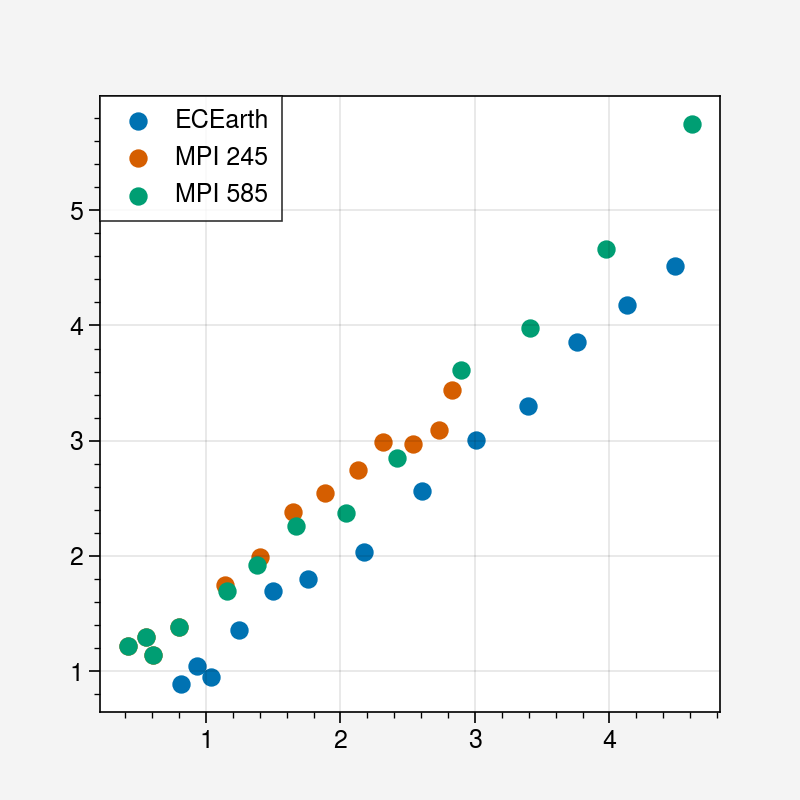

In [24]:
plt.scatter(wrming_20yrs_GCM,wrming_20yrs_MAR,label='ECEarth')
plt.scatter(wrming_20yrs_GCM_245,wrming_20yrs_MAR_245,label='MPI 245')
plt.scatter(wrming_20yrs_GCM_585,wrming_20yrs_MAR_585,label='MPI 585')

plt.legend()